In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import subprocess, glob
import pyranges as pr
import pandas as pd
import numpy as np

As suggested by Encode, quantify ATAC peaks using "signal" (equivalent to normalize with local background in a probablity scale) is less affected by confounding technical bias, allowing for an "unsupervised" analysis. How to build https://github.com/macs3-project/MACS/wiki/Build-Signal-Track

# Build Signal Tracks

In [3]:
all_samples = {
    bam_path.split("/")[1].split(".trim")[0]: bam_path
    for bam_path in glob.glob("bam/*bam")
}.keys()

Calculate signals

In [ ]:
log = open("create_signal_tracks.log", "w")
for sample in all_samples:
    # if "NFKB" not in sample and "ND" not in sample:
    #     continue
    # low peak counts
    macs2_prefix = "/".join(["macs2_results", sample, sample])
    count = sum(1 for line in open(macs2_prefix + "_peaks.narrowPeak"))
    if count <= 10_000:
        continue
    # p value track
    subprocess.run(
        f"rm {macs2_prefix}_ppois_signal.bdg {macs2_prefix}_FC_signal.bdg",
        shell=True,
        stderr=subprocess.DEVNULL
    )

    # get scale factor needed for ppois calculation
    with open(f"{macs2_prefix}_peaks.xls") as stats:
        for line in stats:
            if "# tags after filtering in treatment:" in line:
                scale = int(line.split()[-1]) / 1e6
                break

    log.write(f"@Processing {sample}\n")
    ppois = subprocess.Popen(
        f"macs2 bdgcmp -t {macs2_prefix}_treat_pileup.bdg -c {macs2_prefix}_control_lambda.bdg -m ppois -o {macs2_prefix}_ppois_signal.bdg -S {scale}",
        shell=True,
        stderr=subprocess.DEVNULL,
    )
    # fold change
    fc = subprocess.Popen(
        f"macs2 bdgcmp -t {macs2_prefix}_treat_pileup.bdg -c {macs2_prefix}_control_lambda.bdg -m FE -o {macs2_prefix}_FC_signal.bdg",
        shell=True,
        stderr=subprocess.DEVNULL,
    )
    ppois.wait()
    fc.wait()

log.close()

Sort the signal bedGraph

In [ ]:
for sample in all_samples:
    # low peak counts
    macs2_prefix = "/".join(["macs2_results", sample, sample])
    count = sum(1 for line in open(macs2_prefix + "_peaks.narrowPeak"))
    if count <= 10_000:
        continue
    # sort
    print(f"@Sorting {sample}")
    temp_f = open("temp.bdg", "w")
    ppois = subprocess.Popen(
        f"sort -k1,1 -k2,2 {macs2_prefix}_ppois_signal.bdg",
        shell=True,
        stderr=subprocess.DEVNULL,
        stdout=temp_f,
    )
    ppois.wait()
    temp_f.close()
    subprocess.run(["mv", "temp.bdg", f"{macs2_prefix}_ppois_signal.bdg"])
    
    # fold change
    temp_f = open("temp.bdg", "w")
    fc = subprocess.Popen(
        f"sort -k1,1 -k2,2 {macs2_prefix}_FC_signal.bdg",
        shell=True,
        stderr=subprocess.DEVNULL,
        stdout=temp_f
    )
    fc.wait()
    temp_f.close()
    subprocess.run(["mv", "temp.bdg", f"{macs2_prefix}_FC_signal.bdg"])

@Sorting ATAC188_CB_FR062.1_ND_sB
@Sorting ATAC088_CB_FR028.1_CVID_sB
@Sorting ATAC111_CB_FR036.1_NFKB1_sB
@Sorting ATAC212_CB_FR071.1_CVID_sB
@Sorting ATAC179_CB_FR059.1_TACI_sB
@Sorting ATAC270_CB_FR090.1_CVID_sB
@Sorting ATAC128_CB_FR042.1_CVID_sB
@Sorting ATAC251_CB_FR083.1_CVID_sB
@Sorting ATAC295_BG_FR100.1_NFKB1_sB
@Sorting ATAC158_CB_FR052.1_ND_sB
@Sorting ATAC215_CB_FR072.1_ADA2_sB
@Sorting ATAC055_CB_FR016.1_CTLA4_sB
@Sorting ATAC170_CB_FR056.1_CVID_sB
@Sorting ATAC091_CB_FR029.1_TACI_sB
@Sorting ATAC137_CB_FR045.1_ND_sB
@Sorting ATAC097_CB_FR031.1_CTLA4_sB
@Sorting ATAC117_CB_FR038.1_TACI_sB
@Sorting ATAC203_CB_FR068.1_CVID_sB
@Sorting ATAC230_CB_FR077.1_CVID_sB
@Sorting ATAC149_CB_FR049.1_ND_sB
@Sorting ATAC182_CB_FR060.1_HIES_sB
@Sorting ATAC317_BG_FR108.1_CTLA4_sB


# Find Consensus Peaks
Peaks that were at least shown in two samples

In [4]:
import os

os.environ["R_HOME"] = "/home/murrelab/anaconda3/envs/r-wgcna/lib/R"
import rpy2
from rpy2.robjects import r, pandas2ri, globalenv

%load_ext rpy2.ipython

In [7]:
%%R
suppressPackageStartupMessages(library(DiffBind))
# extract nfkb and nd samples
sample.sheet <- read.csv("SampleSheet.csv")
all.samples <- sample.sheet[, 1:3]
colnames(all.samples) <-  c("SampleID", "Sex", "Replicate")
all.samples$Condition <- as.character(
    lapply(all.samples$SampleID, function (x) {
        s <- unlist(strsplit(x, "_", TRUE))
        s[length(s) - 1]
    })
)
all.samples$Condition <- as.factor(all.samples$Condition)
rownames(all.samples) <- all.samples$SampleID 

# path for peaks and reads
all.samples$bamReads <- paste0("bam/", all.samples$SampleID, ".trimmed.bowtie2.filtered.bam")
all.samples$Peaks <- paste0("macs2_results/", all.samples$SampleID, "/", 
                                all.samples$SampleID, "_peaks.narrowPeak")
all.samples$PeakCaller <- "narrow"

# filter low quality samples that call less than 10k peaks
valid.samples <- lapply(all.samples$Peaks, function (x) {
    if (file.exists(x)) {
        if (nrow(read.csv(x)) >= 10000) {
            return(TRUE)
        }
    }
    FALSE
})
cat(paste(c("Removed samples:", all.samples$SampleID[!unlist(valid.samples)]), " "))
all.samples <- all.samples[unlist(valid.samples), ]
cat("\n")
cat(paste(c("Unique batchs:", unique(all.samples$Replicate)), " "))
cat("\n")
# head(all.samples)

Removed samples:   ATAC024_CB_FR005.1_NFKB1_sB   ATAC033_CB_FR008.1_CTLA4_sB   ATAC036_CB_FR009.1_CTLA4_sB   ATAC039_CB_FR010.1_CTLA4_sB   ATAC042_CB_FR011.1_CVID_sB   ATAC045_CB_FR012.1_CTLA4_sB   ATAC047_CB_FR013.1_CVID_sB   ATAC049_CB_FR014.1_CVID_sB   ATAC066_CB_FR020.1_CVID_sB   ATAC114_CB_FR037.1_CVID_sB   ATAC120_CB_FR039.1_CVID_sB   ATAC161_CB_FR053.1_NFKB1_sB   ATAC308_BG_FR105.1_CTLA4_sB  
Unique batchs:   20200205   20200217   20200602   20200828  


consensus

In [8]:
%%R
db.obj <- dba(sampleSheet = all.samples, bRemoveM = TRUE, minOverlap = 2)
db.obj <- dba.blacklist(db.obj, blacklist = DBA_BLACKLIST_HG38, greylist = FALSE)

R[write to console]: ATAC027_CB_FR006.1_TACI_sB   TACI  20200205 narrow

R[write to console]: ATAC030_CB_FR007.1_CTLA4_sB   CTLA4  20200205 narrow

R[write to console]: ATAC052_CB_FR015.1_CVID_sB   CVID  20200205 narrow

R[write to console]: ATAC055_CB_FR016.1_CTLA4_sB   CTLA4  20200205 narrow

R[write to console]: ATAC058_CB_FR017.1_CVID_sB   CVID  20200205 narrow

R[write to console]: ATAC063_CB_FR019.1_TACI_sB   TACI  20200217 narrow

R[write to console]: ATAC071_CB_FR022.1_TACI_sB   TACI  20200217 narrow

R[write to console]: ATAC074_CB_FR023.1_NFKB1_sB   NFKB1  20200217 narrow

R[write to console]: ATAC077_CB_FR024.1_CVID_sB   CVID  20200217 narrow

R[write to console]: ATAC082_CB_FR026.1_CTLA4_sB   CTLA4  20200217 narrow

R[write to console]: ATAC085_CB_FR027.1_CTLA4_sB   CTLA4  20200217 narrow

R[write to console]: ATAC088_CB_FR028.1_CVID_sB   CVID  20200217 narrow

R[write to console]: ATAC091_CB_FR029.1_TACI_sB   TACI  20200217 narrow

R[write to console]: ATAC094_CB_FR030.1_C

centering

In [9]:
%%R
# db.obj$config$singleEnd <- FALSE
db.obj$config$cores <- 4
db.obj <- dba.count(db.obj)
consensus_peaks <- as.data.frame(dba.peakset(db.obj, bRetrieve=T))[,1:3]
consensus_peaks$seqnames <- as.vector(consensus_peaks$seqnames)

R[write to console]: Computing summits...

R[write to console]: Re-centering peaks...

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flus

In [10]:
all_peaks = pandas2ri.rpy2py_dataframe(r("consensus_peaks"))
all_peaks = all_peaks.rename(
    columns={"seqnames": "Chromosome", "start": "Start", "end": "End"}
)
all_peaks.head(5)

,Chromosome,Start,End
1,chr1,9975,10375
2,chr1,180646,181046
3,chr1,181264,181664
4,chr1,191271,191671
5,chr1,267805,268205


We can also read peaks from previous data

In [7]:
all_peaks = pd.read_csv("0622_All_Samples_Signal_at_Consensus_Peaks.txt", sep="\t")[
    ["Chromosome", "Start", "End"]
]
all_peaks.head(5)

,Chromosome,Start,End
0,chr1,9975,10375
1,chr1,180646,181046
2,chr1,181264,181664
3,chr1,191271,191671
4,chr1,267805,268205


In [18]:
all_peaks[all_peaks.Chromosome == "chr1"].End.max()

248925138

# Integrated with Signals

In [8]:
from pyBedGraph import BedGraph

In [28]:
def _get_chro_signal_from_bedgraph(
    chro, start_pos, end_pos, bdg_file, chrom_size, count_method="mean"
):
    bedgraph = BedGraph(chrom_size, bdg_file, [chro], ignore_missing_bp=False)
    bedgraph.load_chrom_data(chro)
    return bedgraph.stats(
        count_method, start_list=start_pos, end_list=end_pos, chrom_name=chro
    )


def _get_signal_from_sample_bedgraph(sample, regions):
    # low peak counts
    macs2_prefix = "/".join(["macs2_results", sample, sample])
    bdg_file = f"{macs2_prefix}_FC_signal.bdg"
    return regions.groupby("Chromosome", as_index=False).apply(
        lambda df: pd.DataFrame(
            {
                sample: _get_chro_signal_from_bedgraph(
                    df.name,
                    df.Start.values,
                    df.End.values,
                    bdg_file,
                    "hg38_chrom.sizes",
                ),
            },
            index=df.index,
        )
    )

In [10]:
from multiprocessing import Pool

In [30]:
chromosomes = [f"chr{i}" for i in range(1, 23)] + ["chrX"]
all_p_signal = (
    all_peaks[all_peaks.Chromosome.isin(chromosomes)].reset_index(drop=True).copy()
)
all_p_signal["Start"] = all_p_signal.Start.astype(np.int32)
all_p_signal["End"] = all_p_signal.End.astype(np.int32)


samples = []
for sample in all_samples:
    # if "ND" not in sample:
    #     continue
    # low peak counts
    macs2_prefix = "/".join(["macs2_results", sample, sample])
    count = sum(1 for line in open(macs2_prefix + "_peaks.narrowPeak"))
    if count <= 10_000:
        continue
    samples.append(sample)


def f(x):
    return _get_signal_from_sample_bedgraph(x, all_p_signal)


with Pool(8) as p:
    sample_signals = p.map(f, samples)

In [37]:
for sample_signal in sample_signals:
    all_p_signal = pd.concat([all_p_signal, sample_signal], axis=1)

In [38]:
# all_p_signal[(all_p_signal.Chromosome != "chrY")].to_csv(
all_p_signal.to_csv(
    "0622_All_Samples_Signal_at_Consensus_Peaks.txt", sep="\t", index=None
)

# Heatmap

In [40]:
%%R
suppressPackageStartupMessages(library(ComplexHeatmap))
library(repr)
library(circlize)

R[write to console]: ========================================
circlize version 0.4.14
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




In [54]:
%%R
signal_profile <- read.csv("0622_All_Samples_Signal_at_Consensus_Peaks.txt", sep="\t")
rownames(signal_profile) <- paste(signal_profile$Chromosome, signal_profile$Start, signal_profile$End, sep=",")
signal_profile <- signal_profile[, 4:ncol(signal_profile)]
log2_signal <- log2(signal_profile + 1)
log2_signal <- log2_signal[rowSums(log2_signal > log2(4+1)) >  0.2 * ncol(log2_signal), ]

# standardize
filtered <- t(apply(log2_signal, 1, function(x) {
    std <- sd(x)
    if (std==0) {
        std <- NA 
    }
    (x-mean(x)) / std
}))

filtered <- filtered[complete.cases(filtered), ]
dim(filtered)

[1] 48104    72


In [23]:
globalenv["condition"] = pandas2ri.py2rpy(sample_sheet.Condition)
globalenv["affectedlocus"] = pandas2ri.py2rpy(sample_sheet.AffectedLocus)

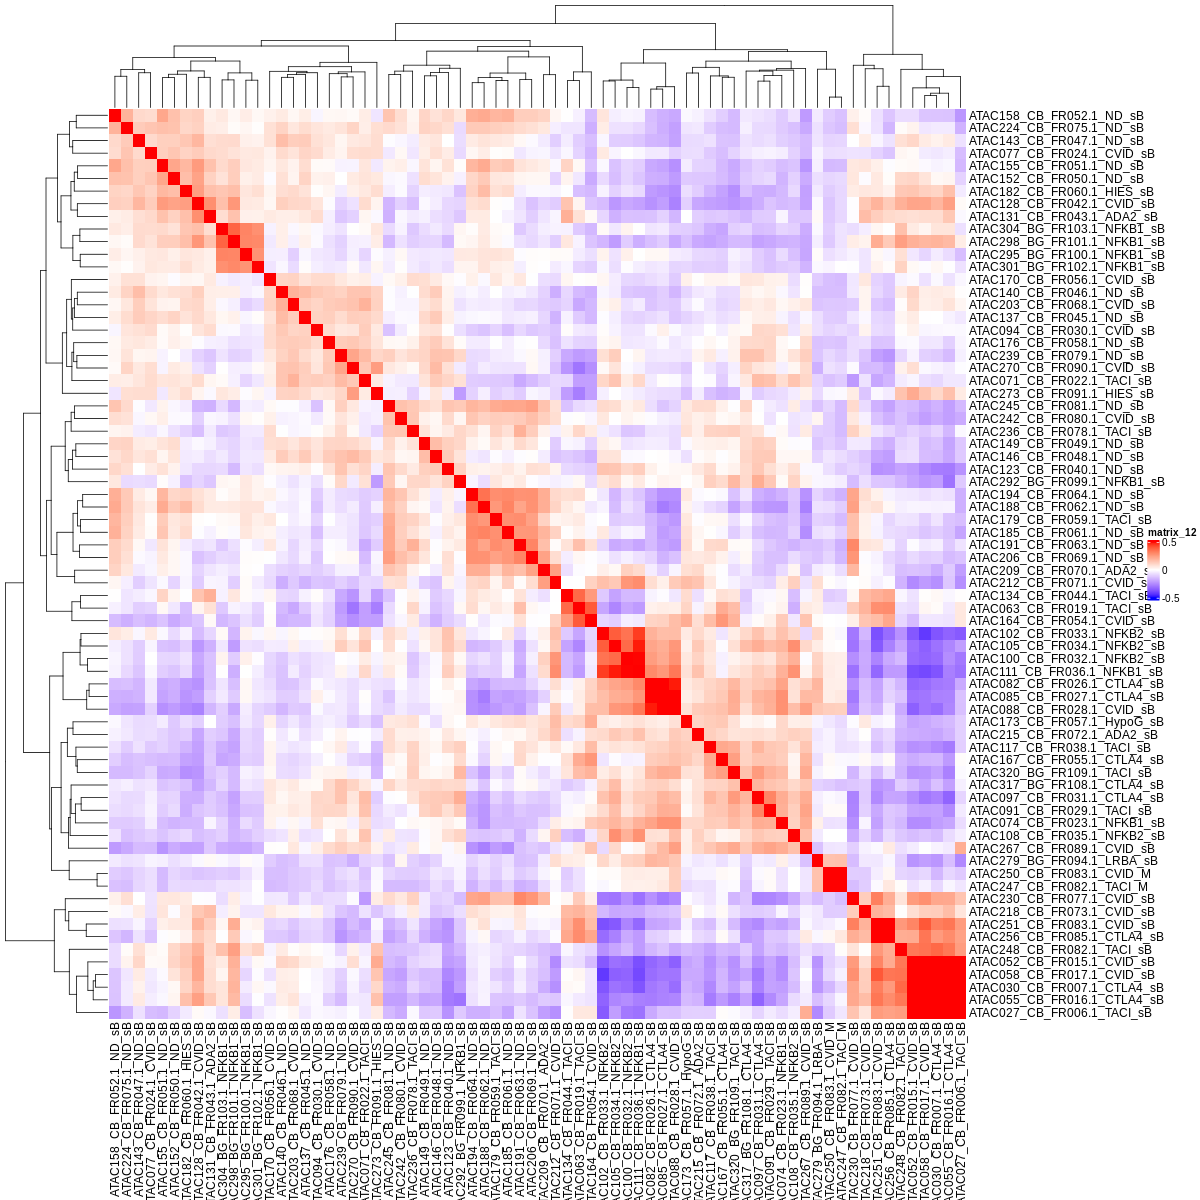

In [57]:
%%R -w 1200 -h 1200
# options(repr.plot.width=15, repr.plot.height=15)
n_samples <- ncol(filtered)
cor_mat <- cor(filtered)

Heatmap(
    cor_mat, 
    row_dend_width = n_samples * unit(0.5, "mm"),
    column_dend_height  = n_samples * unit(0.5, "mm"),
    col=colorRamp2(c(-0.5, 0, 0.5), c("blue", "white", "red"))
)

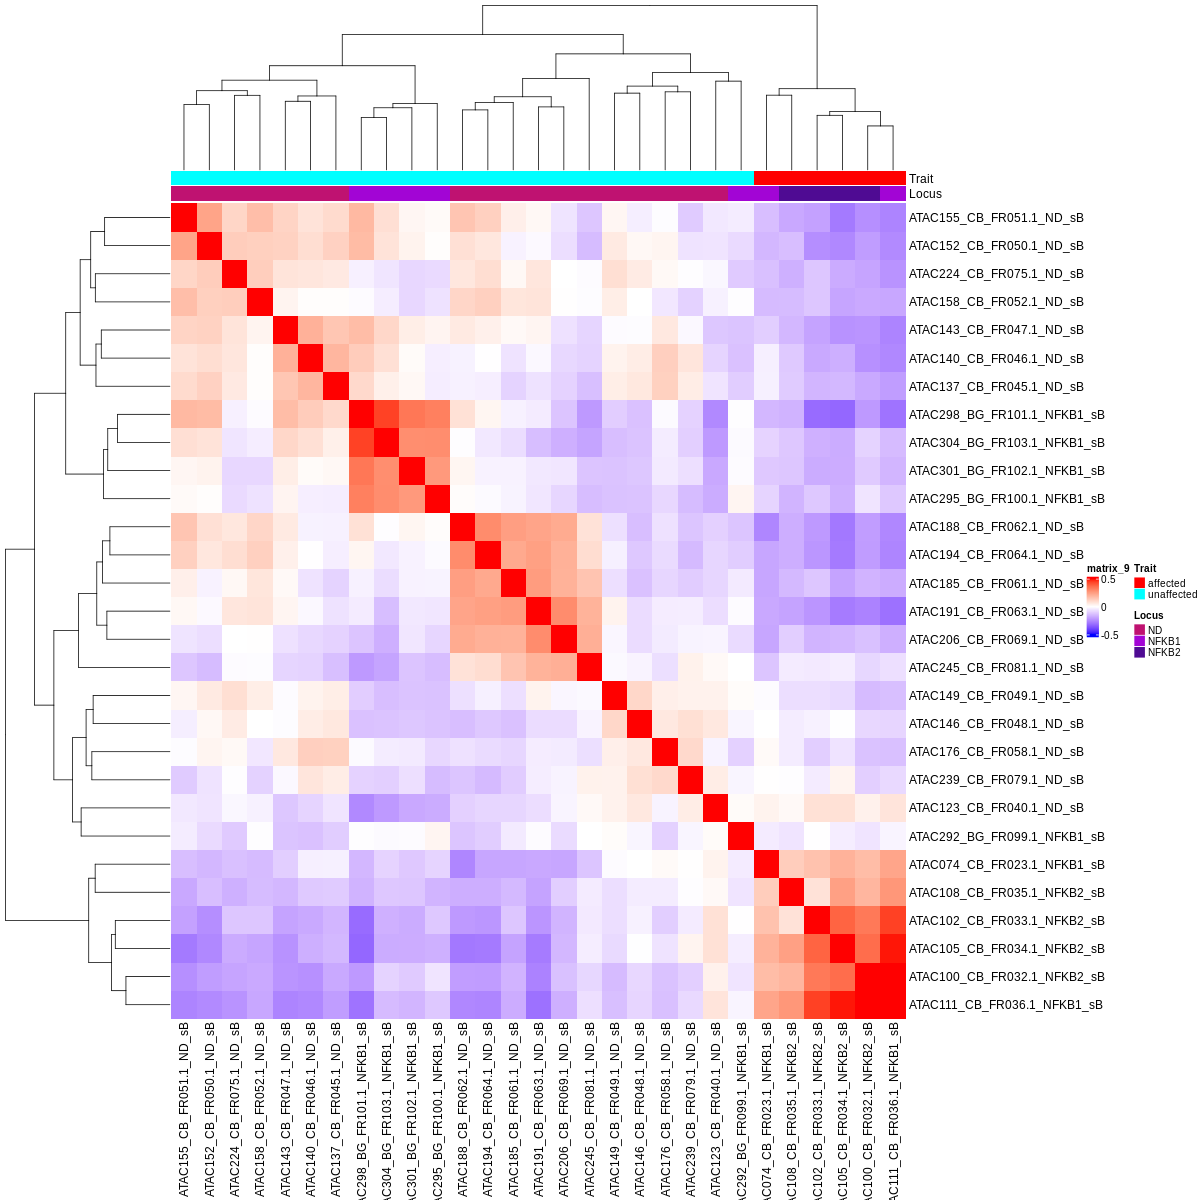

In [25]:
%%R -w 1200 -h 1200
# options(repr.plot.width=15, repr.plot.height=15)
n_samples <- ncol(filtered)
cor_mat <- cor(filtered)
colha <- HeatmapAnnotation(
    Trait = condition[rownames(cor_mat)],
    Locus = affectedlocus[rownames(cor_mat)], 
    which="col", 
    col = list(Trait = c("affected"="red", "unaffected"="cyan"))
)

Heatmap(cor_mat, row_dend_width = n_samples * unit(2, "mm"), column_dend_height  = n_samples * unit(2, "mm"), col=colorRamp2(c(-0.5, 0, 0.5), c("blue", "white", "red")), top_annotation = colha)

# Archive

Add annotation to sample

In [8]:
sample_sheet = pandas2ri.rpy2py(r("nfkb.nd.samples[, 1:4]"))

In [9]:
annotation = {
    "ATAC074_CB_FR023.1_NFKB1_sB": ["haploinsufficient", "affected"],
    "ATAC100_CB_FR032.1_NFKB2_sB": ["haploinsufficient", "affected"],
    "ATAC102_CB_FR033.1_NFKB2_sB": ["haploinsufficient", "affected"],
    "ATAC105_CB_FR034.1_NFKB2_sB": ["haploinsufficient", "affected"],
    "ATAC108_CB_FR035.1_NFKB2_sB": ["haploinsufficient", "affected"],
    "ATAC111_CB_FR036.1_NFKB1_sB": ["precursorskipping", "affected"],
    "ATAC292_BG_FR099.1_NFKB1_sB": ["haploinsufficient", "unaffected"],
    "ATAC295_BG_FR100.1_NFKB1_sB": ["haploinsufficient", "unaffected"],
    "ATAC298_BG_FR101.1_NFKB1_sB": ["haploinsufficient", "unaffected"],
    "ATAC301_BG_FR102.1_NFKB1_sB": ["haploinsufficient", "unaffected"],
    "ATAC304_BG_FR103.1_NFKB1_sB": ["haploinsufficient", "unaffected"],
}

In [10]:
sample_sheet["AffectedLocus"] = [x.rsplit("_")[-2] for x in sample_sheet.SampleID]

temp = []
for sample in sample_sheet.SampleID:
    try:
        temp.append(annotation[sample][0])
    except KeyError:
        temp.append("WT")
sample_sheet["Mutation"] = temp

temp = []
for sample in sample_sheet.SampleID:
    try:
        temp.append(annotation[sample][1])
    except KeyError:
        temp.append("unaffected")
sample_sheet["Condition"] = temp

In [7]:
%%R
suppressPackageStartupMessages(library(DiffBind))
# extract nfkb and nd samples
all.samples <- read.csv("SampleSheet.csv")
nfkb.nd.samples <- all.samples[grepl("ND", all.samples$sample_name) | grepl("NFKB", all.samples$sample_name), 1:3]
colnames(nfkb.nd.samples) <-  c("SampleID", "Sex", "Replicate")
nfkb.nd.samples$Condition <- as.character(
    lapply(nfkb.nd.samples$SampleID, function (x) {
        s <- unlist(strsplit(x, "_", TRUE))
        s[length(s) - 1]
    })
)
nfkb.nd.samples$Condition <- as.factor(nfkb.nd.samples$Condition)
rownames(nfkb.nd.samples) <- nfkb.nd.samples$SampleID 

# path for peaks and reads
nfkb.nd.samples$bamReads <- paste0("bam/", nfkb.nd.samples$SampleID, ".trimmed.bowtie2.filtered.bam")
nfkb.nd.samples$Peaks <- paste0("macs2_results/", nfkb.nd.samples$SampleID, "/", 
                                nfkb.nd.samples$SampleID, "_peaks.narrowPeak")
nfkb.nd.samples$PeakCaller <- "narrow"

# filter low quality samples that call less than 10k peaks
valid.samples <- lapply(nfkb.nd.samples$Peaks, function (x) {
    if (file.exists(x)) {
        if (nrow(read.csv(x)) >= 10000) {
            return(TRUE)
        }
    }
    FALSE
})
cat(paste(c("Removed samples:", nfkb.nd.samples$SampleID[!unlist(valid.samples)]), " "))
nfkb.nd.samples <- nfkb.nd.samples[unlist(valid.samples), ]
cat("\n")
cat(paste(c("Unique batchs:", unique(nfkb.nd.samples$Replicate)), " "))
cat("\n")
# head(nfkb.nd.samples)

Removed samples:   ATAC024_CB_FR005.1_NFKB1_sB   ATAC161_CB_FR053.1_NFKB1_sB  
Unique batchs:   20200217   20200602   20200828  


aggregate by mean

In [ ]:
def _get_fc_signal_from_sample_bedgraph(sample):
    # low peak counts
    macs2_prefix = "/".join(["macs2_results", sample, sample])
    bdg_file = f"{macs2_prefix}_FC_signal.bdg"
    return nfkb_nd_p_signal.groupby("Chromosome", as_index=False).apply(
        lambda df: pd.DataFrame(
            {
                sample: _get_chro_signal_from_bedgraph(
                    df.name,
                    df.Start.values,
                    df.End.values,
                    bdg_file,
                    "hg38_chrom.sizes",
                ),
            },
            index=df.index,
        )
    )


nfkb_nd_p_signal = (
    nfkb_nd_peaks[nfkb_nd_peaks.Chromosome.isin(chromosomes)]
    .reset_index(drop=True)
    .copy()
)

with Pool(5) as p:
    sample_signals = p.map(_get_fc_signal_from_sample_bedgraph, samples)

In [115]:
for sample_signal in sample_signals:
    nfkb_nd_p_signal = pd.concat([nfkb_nd_p_signal, sample_signal], axis=1)

In [156]:
nfkb_nd_p_signal[(nfkb_nd_p_signal.Chromosome != "chrY")].to_csv(
    "NFKB_ND_FC_Signal_at_Consensus_Peaks.txt", sep="\t", index=None
)